# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.13 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [5]:
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import random
import time
import torch
from unityagents import UnityEnvironment

%matplotlib inline


In [6]:
def ddpg(n_episodes=500, max_t=1000, solved_score=30.0, moving_window_size=100, print_every=1, train_mode=True):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        moving_window_size (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results

    """
    score_history = []                               # score list
    scores_deque = deque(maxlen=moving_window_size)  # scores of the most recent episodes
    moving_averages = []                             # list of moving averages
    
    for episode_number in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break
        duration = time.time() - start_time
        score_history.append(np.mean(scores))           # save mean score for the episode
        scores_deque.append(score_history[-1])         # save mean score to window
        moving_averages.append(np.mean(scores_deque))    # save moving average
        
        print(f'Episode {episode_number} (elapsed ({round(duration)}))\tAverage score: {score_history[-1]:.2f}\tMoving Average: {moving_averages[-1]:.2f}')
                  
        if moving_averages[-1] >= solved_score and episode_number >= moving_window_size:
            print(f'\nEnvironment solved in {episode_number} episodes. \tMoving Average ={moving_averages[-1]:.2f} over last {moving_window_size} episodes')
            if train_mode:
                torch.save(agent.actor_local.state_dict(), 'actor_ckpt.pth')
                torch.save(agent.critic_local.state_dict(), 'critic_ckpt.pth')  
            break
            
    return score_history, moving_averages

In [7]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
score_history, avgs = ddpg()

Episode 1 (elapsed (113))	Average score: 0.61	Moving Average: 0.61
Episode 2 (elapsed (116))	Average score: 0.92	Moving Average: 0.77
Episode 3 (elapsed (117))	Average score: 1.98	Moving Average: 1.17
Episode 4 (elapsed (118))	Average score: 2.48	Moving Average: 1.50
Episode 5 (elapsed (119))	Average score: 2.90	Moving Average: 1.78
Episode 6 (elapsed (120))	Average score: 4.37	Moving Average: 2.21
Episode 7 (elapsed (121))	Average score: 3.50	Moving Average: 2.40
Episode 8 (elapsed (122))	Average score: 4.89	Moving Average: 2.71
Episode 9 (elapsed (123))	Average score: 5.77	Moving Average: 3.05
Episode 10 (elapsed (124))	Average score: 6.86	Moving Average: 3.43
Episode 11 (elapsed (125))	Average score: 8.12	Moving Average: 3.85
Episode 12 (elapsed (127))	Average score: 7.96	Moving Average: 4.20
Episode 13 (elapsed (128))	Average score: 7.16	Moving Average: 4.43
Episode 14 (elapsed (130))	Average score: 9.00	Moving Average: 4.75
Episode 15 (elapsed (131))	Average score: 8.34	Moving Ave

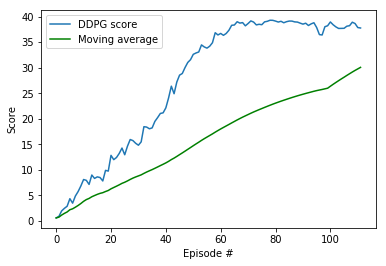

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score_history)), score_history, label='DDPG score')
plt.plot(np.arange(len(score_history)), avgs, c='g', label='Moving average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
fig.savefig('results.png', dpi=400)
plt.show()

When finished, you can close the environment.

In [9]:
env.close()